In [51]:
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [52]:
articledf = pd.read_csv('../data/article_preprocessed.csv')

In [53]:
w2v_model = Word2Vec.load('../models/word2vec_fake_news.model')

In [54]:
texts = articledf['tokens'].tolist()
labels = articledf['target'].values

In [55]:
# Create word-index mapping (start from 1, reserve 0 for padding)
word_index = {word: i + 1 for i, word in enumerate(w2v_model.wv.index_to_key)}
vocab_size = len(word_index) + 1  # +1 for padding

# Convert text to sequence of indices
def tokens_to_indices(tokens):
    return [word_index.get(token, 0) for token in tokens]

sequences = [tokens_to_indices(tokens) for tokens in texts]

# Pad sequences
max_len = 300  # You can also compute 95th percentile of sequence lengths
X = pad_sequences(sequences, maxlen=max_len, padding='post')
y = labels

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [57]:
X_train.shape, X_test.shape

((33673, 300), (11225, 300))

In [58]:
embedding_dim = w2v_model.vector_size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [75]:
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=False),  # freeze embeddings
    GRU(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │    12,826,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,826,300 (48.93 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 12,826,300 (48.93 MB)

In [76]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [77]:
with tf.device('/GPU:0'):  # Ensures it runs on GPU if available
    history = model.fit(
        X_train, y_train,
        validation_split=0.1,
        epochs=10,
        batch_size=128,
        verbose=1,
        callbacks=[tensorboard_cb]
    )

Epoch 1/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 138s 579ms/step - accuracy: 0.8710 - loss: 0.3426 - val_accuracy: 0.9323 - val_loss: 0.2071
Epoch 2/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 137s 580ms/step - accuracy: 0.9344 - loss: 0.2153 - val_accuracy: 0.9365 - val_loss: 0.1905
Epoch 3/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 146s 615ms/step - accuracy: 0.9443 - loss: 0.1813 - val_accuracy: 0.9332 - val_loss: 0.2041
Epoch 4/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 141s 595ms/step - accuracy: 0.9475 - loss: 0.1741 - val_accuracy: 0.9463 - val_loss: 0.1748
Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 142s 600ms/step - accuracy: 0.9479 - loss: 0.1626 - val_accuracy: 0.9469 - val_loss: 0.1721
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 138s 582ms/step - accuracy: 0.9515 - loss: 0.1583 - val_accuracy: 0.9477 - val_loss: 0.1615
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 139s 587ms/step - accuracy: 0.9512 - loss: 0.1489 - val_accuracy: 0.9498 - val_loss: 0.1374
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 142s 600ms/step - accuracy: 0.9542 -

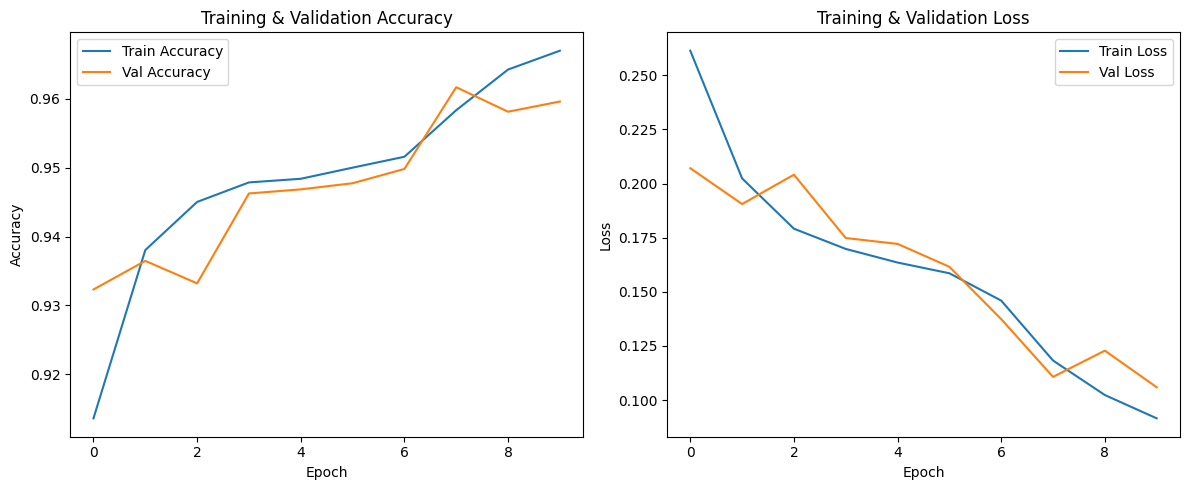

In [78]:
# Plot training & validation accuracy/loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [79]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

351/351 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.9617 - loss: 0.1017
Test Accuracy: 0.9627


351/351 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step


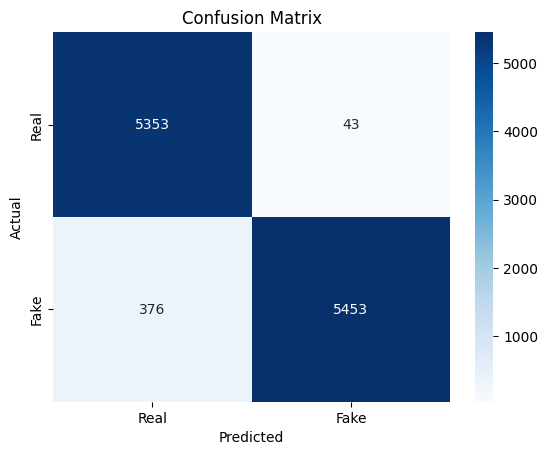

              precision    recall  f1-score   support

        Real       0.93      0.99      0.96      5396
        Fake       0.99      0.94      0.96      5829

    accuracy                           0.96     11225
   macro avg       0.96      0.96      0.96     11225
weighted avg       0.96      0.96      0.96     11225



In [80]:
# Predict on test set
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'],
            yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

In [81]:
model.save("../models/gru_fake_news_model.keras")
model.save_weights("../models/gru_fake_news.weights.h5")

In [82]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
